# COGS 108 - Predicting the first COVID-free state

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [`X`] YES - make available
* [  ] NO - keep private

# Overview

As we reach the anniversary of the COVID-19 pandemic reaching the United States, our group sought to analyze the competing and similar trends across the states to see how each fared against the spread of the virus. Exploring both the daily and overall rates of vaccinations, hospitalizations, and COVID cases against population, we ranked each state on these factors - postulating that their relative success in the sum of these trends will roughly translate to which states will reach herd immunity/ be COVID-free first. 

# Names

- Anna Wang
- Chloe Salem
- Kristy Liou
- Maxtierney Arias
- Zeven Vidmar Barker

# Research Question

Can we predict which state in the USA will be covid-free first based on current hospital records, vaccination rates, and population?

<a id='background'></a>

## Background & Prior Work

**Background**

This research question came to be of interest to our group due to the recent release of COVID-19 vaccinations in the US. On February 11th, President Biden and his administration claimed to have finalized deals for another 200 million doses of the two coronavirus vaccines (Moderna and Pfizer) authorized in the United States, supposedly giving the country enough vaccines to cover every American adult by the end of July 2021.
Within the course of this pandemic thus far, different states are evidently handling the spread of COVID-19 inconsistently. Confirmed COVID cases in the USA increased rapidly during mid-March and each state administered different shelters in place, lockdown, social distancing, and essential activity restrictions to reduce and slow down the spread of the virus. However, even with these different restrictions in place, citizens of these states do not always follow these guidelines as they are supposed to which can lead to further spread of the virus despite the state’s intentions.
With this information in mind and Biden’s new vaccination plan announced, we were curious as to which state would be free of COVID first based on how that state is currently doing in terms of hospitalized covid cases, the current amount of vaccinated state citizens, and the population of each state.


**Prior Work**

Prior to our research project, there have been predictions made about when COVID-19 will end in the US. In an article by McKinsey & Company, they believed that the United States will most likely go back to normal in the second quarter of 2021 and obtain herd immunity in the third and fourth quarters. In this article, they mainly talk about when the US in general will transition back to normalcy assuming that vaccines are being administered at the pace they are currently being rolled out. However, they do not take into account each state’s individual activity regarding hospitalization and whether citizens are actually following COVID guidelines but rather approaches a more general outlook on the situation.

References (include links):
- 1) <a href="https://ballotpedia.org/States_that_did_not_issue_stay-at-home_orders_in_response_to_the_coronavirus_(COVID-19">Different States’ Approaches to COVID-19 Stay at Home Orders</a>
- 2) [Biden’s Announcement on Increased Vaccine Supply](https://www.whitehouse.gov/briefing-room/statements-releases/2021/02/02/fact-sheet-president-biden-announces-increased-vaccine-supply-initial-launch-of-the-federal-retail-pharmacy-program-and-expansion-of-fema-reimbursement-to-states/)
- 3) [Predicting when the COVID-19 Pandemic Will End](https://www.mckinsey.com/industries/healthcare-systems-and-services/our-insights/when-will-the-covid-19-pandemic-end#)
- 4) [When will COVID-19 End? Data-Driven Prediction](https://web.persi.or.id/images/2020/data/covid19_prediction_paper.pdf)

# Hypothesis


We believe that states that are distributing vaccinations at a higher rate, have lower overall populations, and have hospitals that are operating below full capacity will be COVID-free first. Based on how states are operating currently, we believe that one of the Midwestern (Nebraska, Kansas, etc) or Western States (Oregon, Utah, Wyoming) will be COVID free first.

# Dataset(s)

To answer our question, we will utilize data on hospital capacity by state, vaccinations in each state, and COVID cases by state, combined with population data sourced from the US Census. 

- Dataset Name: **Population, Population Changes, and Estimates**
- Link to the dataset: https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/national/totals/nst-est2020.csv
- Number of observations: The US Census dataset from 2010 includes populations of the country, states, and regions as well as estimates of each for every year leading up to 2020. This dataset is the best available given that the 2020 census is still being processed.


- Dataset Name: **US State Vaccinations**
- Link to the dataset: https://github.com/owid/covid-19-data/blob/master/public/data/vaccinations/us_state_vaccinations.csv
- It has 2104 observations, which include data on how many people from each state has been vaccinated starting from January 12, 2021.  These observations are broken down by day, which will allow us to analyze the rate at which vaccines are being received and distributed in each state. The dataset features the total number of vaccinations a state has each day with the total number of vaccinations distributed per day.


- Dataset Name: **COVID Tracking**
- Link to the dataset: https://covidtracking.com/data
- It has 2,006 observations, that shows us the number of COVID cases for each state in the US since January 12, 2020, along with patient hospitalization data by state, data on deaths, and COVID testing information. We will be utilizing hospitalization data and testing information.


# Setup

In [1]:
# pip install -U seaborn
# pip install plotly
#conda install -c plotly plotly-orca==1.2.1

#importing needed libraries
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# reading data sets
population = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/national/totals/nst-est2020.csv")
vaccinations = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')
case_tracking = pd.read_csv('https://covidtracking.com/data/download/all-states-history.csv')

#supporting data of state codes used for data cleaning
state_code = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')

# Data Cleaning

## Part 1: Initial Cleaning

First we cleaned the population dataset by all of the columns except for state and estimate 2020 population. Then for the case tracking and vaccination dataset, we removed all of the columns that did not have information regarding the hospitalization, vaccination, and covid cases records. From the case tracking dataset, we removed the columns regarding the death counts. For the vaccination dataset, we removed forms of counting vaccinations we would not need.

In [2]:
# Removed unnecessary columns in Population dataframe
population = population[5::]
population = population[['NAME', 'POPESTIMATE2020']]
population.rename(columns={"NAME": "state", "POPESTIMATE2020": "2020 population"}, errors="raise", inplace=True)
population = population[population.state != 'District of Columbia']
population.reset_index(drop=True, inplace=True)
population.head()

,state,2020 population
0,Alabama,4921532
1,Alaska,731158
2,Arizona,7421401
3,Arkansas,3030522
4,California,39368078


In [3]:
vaccinations.columns

Index(['date', 'location', 'total_vaccinations', 'total_distributed',
       'people_vaccinated', 'people_fully_vaccinated_per_hundred',
       'total_vaccinations_per_hundred', 'people_fully_vaccinated',
       'people_vaccinated_per_hundred', 'distributed_per_hundred',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'daily_vaccinations_per_million', 'share_doses_used'],
      dtype='object')

In [4]:
# Removed unnecessary columns in vaccinations and renamed for easier readability 
vaccinations = vaccinations.drop(['daily_vaccinations_per_million', 'share_doses_used', 'daily_vaccinations_per_million', 'share_doses_used', 'daily_vaccinations_raw','people_fully_vaccinated_per_hundred','people_vaccinated_per_hundred','total_vaccinations_per_hundred', 'distributed_per_hundred'], 1)
new_names = []
for col in vaccinations.columns:
    new_names.append(col.replace('_', ' '))
vaccinations.rename(columns=dict(zip(vaccinations.columns, new_names)), inplace=True)

In [5]:
# Dropping more unrelated columns to research question - including deaths, antibody tests, negative results, and positive results related to type of test
case_tracking = case_tracking[['date', 'state', 'hospitalized', 'hospitalizedCumulative', 'hospitalizedCurrently', 'hospitalizedIncrease', 'positive', 'totalTestResults', 'totalTestResultsIncrease', 'positiveCasesViral', 'positiveIncrease']]
new_names = []
for name in case_tracking.columns:
    new_names.append((re.sub(r"(\w)([A-Z])", r"\1 \2", name)).lower())
case_tracking.rename(columns=dict(zip(case_tracking.columns, new_names)), inplace=True)

In [6]:
case_tracking.head()

,date,state,hospitalized,hospitalized cumulative,hospitalized currently,hospitalized increase,positive,total test results,total test results increase,positive cases viral,positive increase
0,2021-03-07,AK,1293.0,1293.0,33.0,0,56886.0,1731628.0,0,NaN,0
1,2021-03-07,AL,45976.0,45976.0,494.0,0,499819.0,2323788.0,2347,392077.0,408
2,2021-03-07,AR,14926.0,14926.0,335.0,11,324818.0,2736442.0,3380,255726.0,165
3,2021-03-07,AS,NaN,NaN,NaN,0,0.0,2140.0,0,NaN,0
4,2021-03-07,AZ,57907.0,57907.0,963.0,44,826454.0,7908105.0,45110,769935.0,1335


In [7]:
vaccinations.head()

,date,location,total vaccinations,total distributed,people vaccinated,people fully vaccinated,daily vaccinations
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,7270.0,NaN
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,9245.0,5906.0
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,7083.0
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,13488.0,7478.0
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,7498.0


## Part 2: Dataset Merging
After removing the unnecessary columns, we took a dataframe that contains information about the different identifies of state names and unabbreviated the case tracking dataset's state column in order to match the format of the vaccination dataset location column. Then we removed the information of the territories of the US in both dataset because we will only analyze US states. After cleaning the case tracking and vaccination dataset, we merge using a left join based off of the state and date variable to create one big dataset.

This new dataset will contain case tracking variables and vaccination variable for each corresponding state and date. Since vaccination data has only started in 1/3/2021, information regarding vaccination prior to that data will be null values.

In [8]:
# Converting case-tracker state from Abbreviation
for i,j in state_code.iterrows():
    state_code.loc[i]['Abbreviation']
    case_tracking.loc[case_tracking.state == state_code.loc[i]['Abbreviation'], ['state']] = state_code.loc[i]['State']

# Removing the US territory data from the datasets
territories = ['AS', 'GU', 'MP', 'VI', 'PR', 'DC', 'American Samoa', 
               'Federated States of Micronesia', 'Indian Health Svc', 'Guam','Long Term Care',
               'Virgin Islands','Veterans Health', 'Republic of Palau','Puerto Rico', 'Bureau of Prisons',
             'Marshall Islands','Northern Mariana Islands','Dept of Defense','United States', 'District of Columbia']
case_tracking = case_tracking[~case_tracking.state.isin(territories)]
vaccinations = vaccinations[~vaccinations.location.isin(territories)]
vaccinations.loc[vaccinations.location == 'New York State', ['location']] = 'New York'

# Checking if case_tracking and vaccinations have the same states
for i in case_tracking['state'].unique():
    if i not in vaccinations['location'].unique():
        print(i)
vaccinations.rename(columns={'location':'state'},inplace=True)

# Joining case_tracking and vaccination dataframes into one
#merged_data = case_tracking.merge(vaccinations, how='right', on = ['date', 'state'])
merged_data = pd.merge(case_tracking, vaccinations, on = ['date', 'state'], how='left')
merged_data_big = pd.merge(case_tracking, vaccinations, on = ['date', 'state'], how='left')
merged_data = merged_data.head(len(vaccinations))

In [9]:
merged_data

,date,state,hospitalized,hospitalized cumulative,hospitalized currently,hospitalized increase,positive,total test results,total test results increase,positive cases viral,positive increase,total vaccinations,total distributed,people vaccinated,people fully vaccinated,daily vaccinations
0,2021-03-07,Alaska,1293.0,1293.0,33.0,0,56886.0,1731628.0,0,NaN,0,295046.0,426715.0,180948.0,113787.0,4329.0
1,2021-03-07,Alabama,45976.0,45976.0,494.0,0,499819.0,2323788.0,2347,392077.0,408,1110132.0,1628350.0,727681.0,406723.0,23947.0
2,2021-03-07,Arkansas,14926.0,14926.0,335.0,11,324818.0,2736442.0,3380,255726.0,165,765260.0,1088150.0,489149.0,274376.0,16564.0
3,2021-03-07,Arizona,57907.0,57907.0,963.0,44,826454.0,7908105.0,45110,769935.0,1335,2162602.0,2623735.0,1388900.0,715023.0,52879.0
4,2021-03-07,California,NaN,NaN,4291.0,0,3501394.0,49646014.0,133186,3501394.0,3816,10634752.0,13885120.0,7205989.0,3347266.0,259101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,2021-01-03,Vermont,NaN,NaN,31.0,0,7793.0,711104.0,2858,7600.0,104,NaN,NaN,NaN,NaN,NaN
3196,2021-01-03,Washington,14748.0,14748.0,1138.0,0,246752.0,3836820.0,0,237165.0,0,NaN,NaN,NaN,NaN,NaN
3197,2021-01-03,Wisconsin,21529.0,21529.0,1018.0,80,526245.0,5411129.0,8455,486531.0,2593,NaN,NaN,NaN,NaN,NaN
3198,2021-01-03,West Virginia,NaN,NaN,805.0,0,91058.0,1540159.0,7455,73829.0,1731,NaN,NaN,NaN,NaN,NaN


In [10]:
population

,state,2020 population
0,Alabama,4921532
1,Alaska,731158
2,Arizona,7421401
3,Arkansas,3030522
4,California,39368078
5,Colorado,5807719
6,Connecticut,3557006
7,Delaware,986809
8,Florida,21733312
9,Georgia,10710017


## Part 3: Null Data Handling
Here, we further took a look at our dataset's variables. We specifically looked at California's data to see which columns seem to be missing values. From below, it seemed like the columns `hospitialized` and `hospitalized cumulative` seemed to be missing alot of values. We then looked at the entire dataset to see if California had any information within the these columns prior to the date 1/12/2021, and it did not, so we deleted the columns.  

Then further looking into the dataset, it seems like certain values at NaN at the start of the datasets, as well as recent rows that have been added, but information has not yet been put in. We delete the recent rows because it contains mostly NaN values for majority of the states. We also remove the some of the earliest dates because it is difficult to imputate and estimate the data values without knownledge of prior day values of certain states.

After removing those specific rows with the dates, we filtered through the dataset and filled in the NaN values with estimates using imputation since the cases tend to be consistent and continuous in small time ranges. To get these estimates, we took the prior and next day value of a specific column, then found the difference between the two and divided it by 2. We took this value and subtracted it from the next day value. This is the value we used to replace the current row's NaN values. This is done with the function `imputation()`.


In [11]:
merged_data.isnull().sum()

date                             0
state                            0
hospitalized                   832
hospitalized cumulative        832
hospitalized currently           0
hospitalized increase            0
positive                         0
total test results               0
total test results increase      0
positive cases viral           728
positive increase                0
total vaccinations             650
total distributed              650
people vaccinated              659
people fully vaccinated        710
daily vaccinations             500
dtype: int64

In [12]:
# Checking whether some variables are the same 
comparison_column = np.where(merged_data["hospitalized"] == merged_data["hospitalized cumulative"], True, False)
merged_data['hospital check'] = comparison_column
num = merged_data[merged_data['hospital check'] == False]['hospitalized'].count()
print('Checking whether hospitalization column and hospital column are different : ' + str(num))

# Checking on the if there is even data on hospitalized variable in the larger dataset
merged_data2 = pd.merge(case_tracking, vaccinations, on = ['date', 'state'], how='left')
merged_data2.head(-1)
california = merged_data2[merged_data2['state'] == 'California']
num = california['hospitalized'].count()
print('California Hospitalized column count : ' + str(num))

# Since these columns don't have data at all for one state, better to remove it
merged_data = merged_data.drop(columns=['hospitalized', 'hospitalized cumulative', 'positive cases viral'])
merged_data.isnull().sum()

Checking whether hospitalization column and hospital column are different : 0
California Hospitalized column count : 0


date                             0
state                            0
hospitalized currently           0
hospitalized increase            0
positive                         0
total test results               0
total test results increase      0
positive increase                0
total vaccinations             650
total distributed              650
people vaccinated              659
people fully vaccinated        710
daily vaccinations             500
hospital check                   0
dtype: int64

In [13]:
merged_data = merged_data.head(2600)

In [14]:
def imputation():
    count = 0
    col = ['total vaccinations', 'total distributed', 'people vaccinated','people fully vaccinated']
    
    for (index_label, row_series) in merged_data.iloc[::-1].iterrows():
        #print('Row Index label : ', index_label)
        #print('Row Content as Series : ', row_series.values)
        if merged_data.loc[index_label, 'date'] == '2021-01-18':
            #state = merged_data.loc[index_label, 'state']
            for i in range(0, len(col)):
                var = col[i]
                upper_bound = merged_data.loc[index_label - 50, var]
                lower_bound = merged_data.loc[index_label + 150, var]
                #print(index_label)

                difference = upper_bound - lower_bound
                avg = difference // 4
                
                merged_data.loc[index_label, var] = upper_bound - avg
                merged_data.loc[index_label + 50, var] = upper_bound - (2*avg)
                merged_data.loc[index_label + 100, var] = upper_bound - (3*avg)
                
                
    columns = merged_data.columns.tolist()
    for (index_label, row_series) in merged_data.iloc[::-1].iterrows():
        merged_data.loc[index_label, :].isnull()
        null_val = merged_data.loc[index_label, :].isnull().tolist()
        if (merged_data.loc[index_label, 'date'] == '2021-01-13'):
            continue
        #print(merged_data.loc[index_label, columns[i]])
        for i in range(0, len(null_val)):
            if null_val[i]:
                upper = merged_data.loc[index_label - 50, columns[i]]
                lower = merged_data.loc[index_label + 50, columns[i]]
                difference = upper - lower
                avg = difference / 2

                merged_data.loc[index_label, columns[i]] = merged_data.loc[index_label + 50, columns[i]] + avg
        
imputation()
merged_data.isnull().sum()

date                           0
state                          0
hospitalized currently         0
hospitalized increase          0
positive                       0
total test results             0
total test results increase    0
positive increase              0
total vaccinations             0
total distributed              0
people vaccinated              0
people fully vaccinated        0
daily vaccinations             0
hospital check                 0
dtype: int64

In [15]:
merged_data.head(-1)

,date,state,hospitalized currently,hospitalized increase,positive,total test results,total test results increase,positive increase,total vaccinations,total distributed,people vaccinated,people fully vaccinated,daily vaccinations,hospital check
0,2021-03-07,Alaska,33.0,0,56886.0,1731628.0,0,0,295046.0,426715.0,180948.0,113787.0,4329.0,True
1,2021-03-07,Alabama,494.0,0,499819.0,2323788.0,2347,408,1110132.0,1628350.0,727681.0,406723.0,23947.0,True
2,2021-03-07,Arkansas,335.0,11,324818.0,2736442.0,3380,165,765260.0,1088150.0,489149.0,274376.0,16564.0,True
3,2021-03-07,Arizona,963.0,44,826454.0,7908105.0,45110,1335,2162602.0,2623735.0,1388900.0,715023.0,52879.0,True
4,2021-03-07,California,4291.0,0,3501394.0,49646014.0,133186,3816,10634752.0,13885120.0,7205989.0,3347266.0,259101.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,2021-01-15,Virginia,3147.0,146,422634.0,4730680.0,23966,4795,244234.0,852725.0,214732.0,28164.0,17876.0,True
2595,2021-01-15,Vermont,45.0,0,9734.0,788759.0,9581,161,32470.0,74000.0,28355.0,4100.0,2238.0,False
2596,2021-01-15,Washington,1105.0,0,283777.0,4153214.0,24797,2575,242606.0,696175.0,200682.0,31581.0,15680.0,True
2597,2021-01-15,Wisconsin,998.0,119,563866.0,5745570.0,29446,2706,169803.0,437900.0,151387.0,17108.0,10850.0,True


# Data Analysis & Results

## Part 1: Looking at Population and COVID Cases

First we decided to analyze our population dataset by looking at the histogram and distribution plot.
From the results we see that more than half of US states have less than 10 million in population. After we made a barplot that shows each state's population, where we can see which states have a larger population count.

Then, we created a choropleth showing proportion of positive cases for COVID within the USA. This graph gives us an idea of which state in the US had a higher proportion of positive cases regarding their population number.

[Text(0.5, 1.0, 'Counts of State Populations'),
 Text(0.5, 0, '2020 Population (Millions)')]

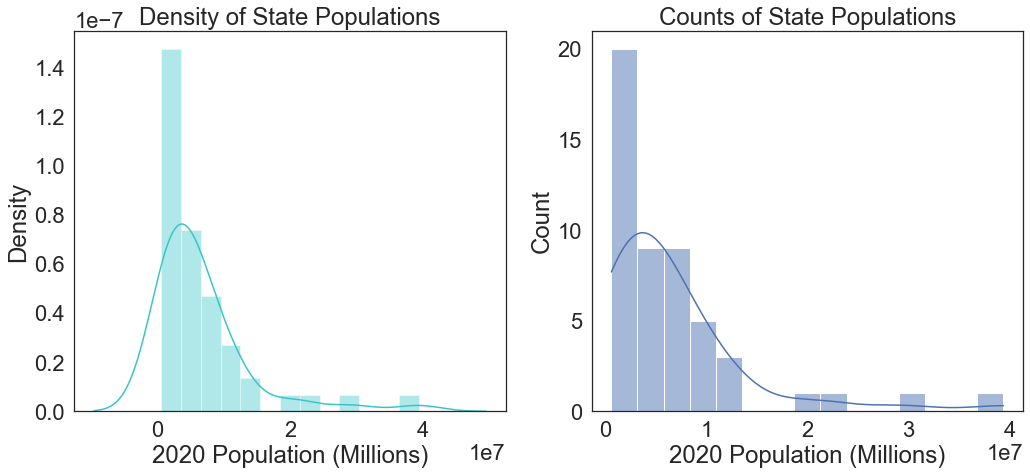

In [16]:
#change style and graphic sizes
sns.set(style="white", font_scale=2)
plt.rcParams['figure.figsize'] = (17, 7)

#removes top and right lines of graph
sns.despine()

#side by side plots
plt.subplot(1, 2, 1)
sns.distplot(population['2020 population'], color='#3BC4C7').set(title="Density of State Populations", xlabel="2020 Population (Millions)")

plt.subplot(1, 2, 2)
sns.histplot(population['2020 population'], bins=15, kde=True).set(title="Counts of State Populations", xlabel="2020 Population (Millions)")

Text(0.5, 0, '2020 Population (Millions)')

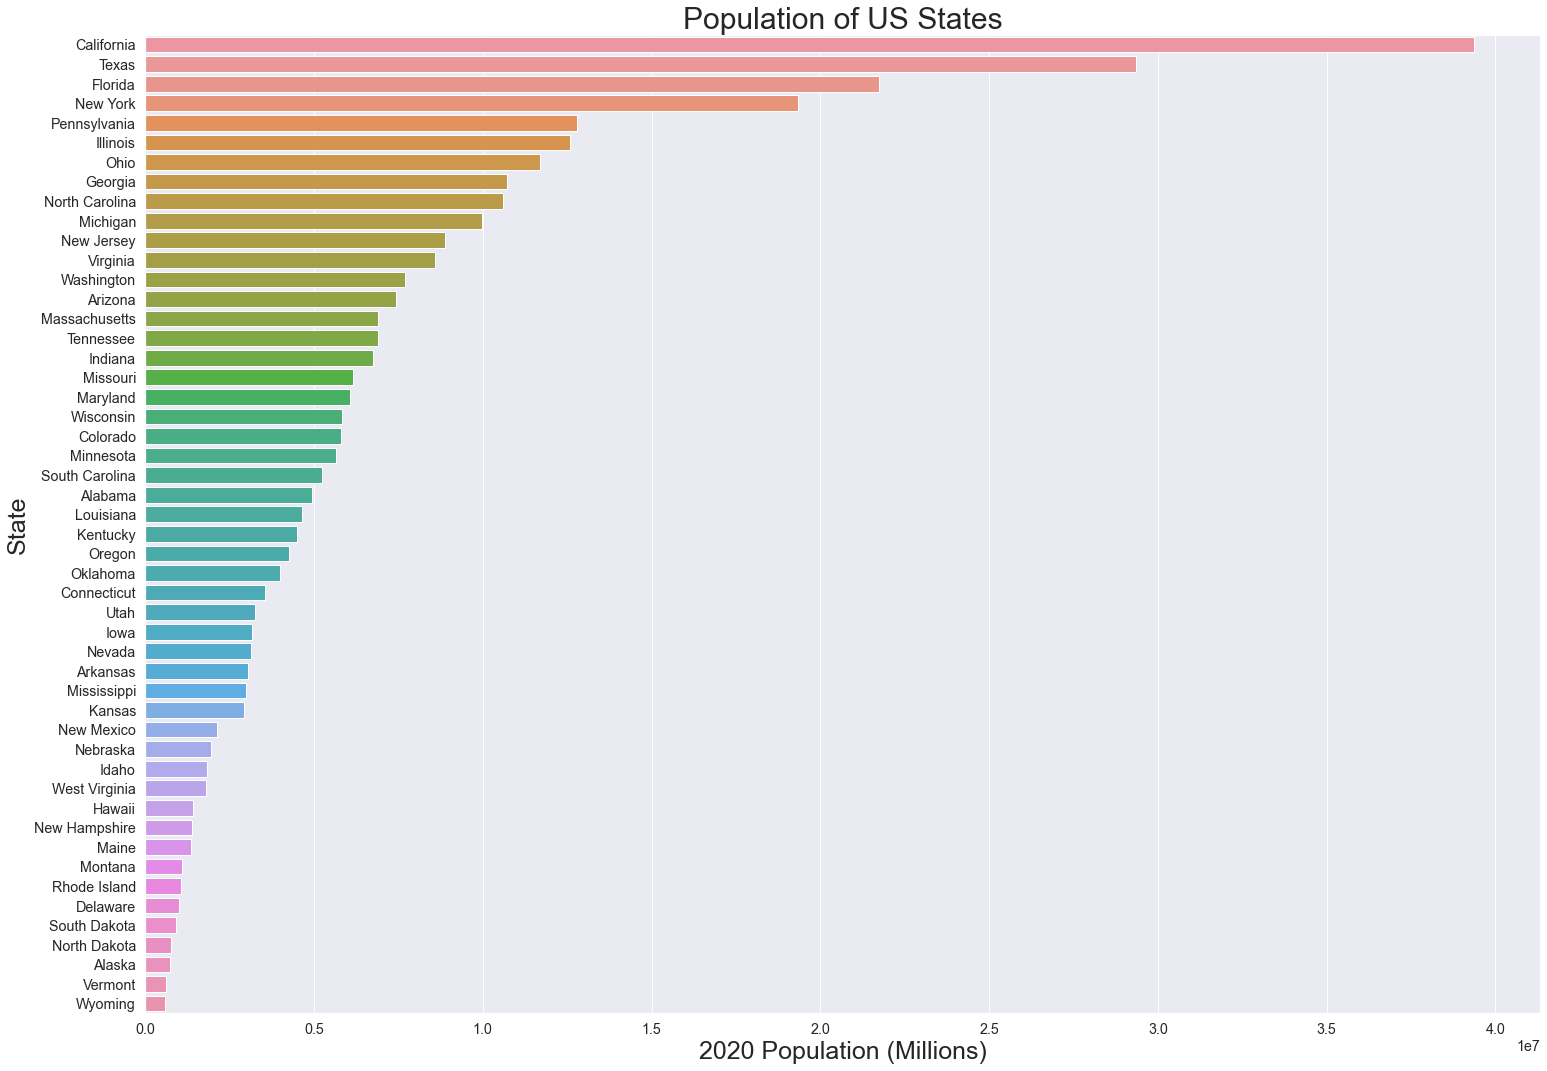

In [17]:
sns.set(rc={'figure.figsize':(25,18)}, font_scale=1.3)
pop = sns.barplot(x=population['2020 population'], y='state', data=population, order=population.sort_values('2020 population',ascending = False).state)

#Relabelling and scaling labels
pop.set_title("Population of US States", fontsize=30)
pop.set_ylabel("State", fontsize=25)
pop.set_xlabel("2020 Population (Millions)", fontsize=25)

When calculating the proportion, we used the most recent rows of each state and stored it in a seperate dataset called `most_recent`. We added a column with the state population. Then we added two other columns showing positive COVID count proportion and positive COVID cases increase proportion relative to the states' population count. This can be seen in the columns `2020 population proportion`, `proportion positive`, and `positive increase` respectively. 

In [18]:
most_recent = merged_data[merged_data['date'] == '2021-03-07']
most_recent = pd.merge(most_recent, population, on = ['state'], how='left')
most_recent['proportion increase'] = most_recent['positive increase']/most_recent['2020 population']
most_recent['proportion positive'] = most_recent['positive']/most_recent['2020 population']
most_recent

,date,state,hospitalized currently,hospitalized increase,positive,total test results,total test results increase,positive increase,total vaccinations,total distributed,people vaccinated,people fully vaccinated,daily vaccinations,hospital check,2020 population,proportion increase,proportion positive
0,2021-03-07,Alaska,33.0,0,56886.0,1731628.0,0,0,295046.0,426715.0,180948.0,113787.0,4329.0,True,731158,0.000000,0.077803
1,2021-03-07,Alabama,494.0,0,499819.0,2323788.0,2347,408,1110132.0,1628350.0,727681.0,406723.0,23947.0,True,4921532,0.000083,0.101558
2,2021-03-07,Arkansas,335.0,11,324818.0,2736442.0,3380,165,765260.0,1088150.0,489149.0,274376.0,16564.0,True,3030522,0.000054,0.107182
3,2021-03-07,Arizona,963.0,44,826454.0,7908105.0,45110,1335,2162602.0,2623735.0,1388900.0,715023.0,52879.0,True,7421401,0.000180,0.111361
4,2021-03-07,California,4291.0,0,3501394.0,49646014.0,133186,3816,10634752.0,13885120.0,7205989.0,3347266.0,259101.0,False,39368078,0.000097,0.088940
5,2021-03-07,Colorado,326.0,18,436602.0,6415123.0,38163,840,1626499.0,2019460.0,1046640.0,567922.0,36417.0,True,5807719,0.000145,0.075176
6,2021-03-07,Connecticut,428.0,0,285330.0,6520366.0,0,0,1195617.0,1434565.0,856048.0,325922.0,27307.0,True,3557006,0.000000,0.080216
7,2021-03-07,Delaware,104.0,0,88354.0,1431942.0,5867,215,275467.0,361765.0,169956.0,97981.0,8022.0,False,986809,0.000218,0.089535
8,2021-03-07,Florida,3307.0,92,1909209.0,22339182.0,64599,4024,5900450.0,7771315.0,3714407.0,2045028.0,122290.0,True,21733312,0.000185,0.087847
9,2021-03-07,Georgia,2008.0,35,1023487.0,7359069.0,18827,1709,2366573.0,3437635.0,1396280.0,894327.0,42017.0,True,10710017,0.000160,0.095564


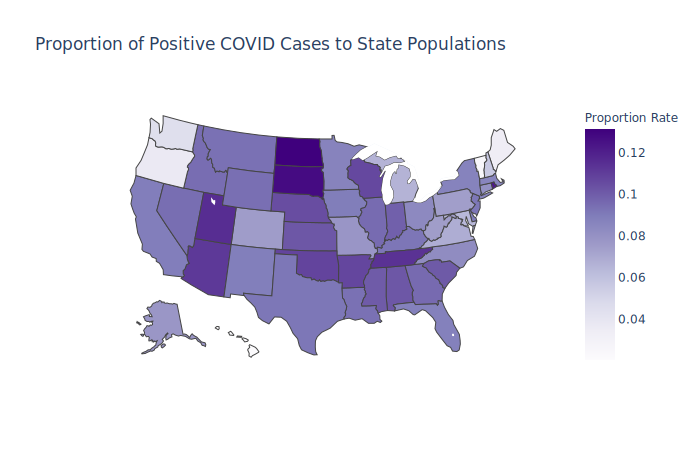

In [19]:
for i,j in state_code.iterrows():
    most_recent.loc[most_recent.state == state_code.loc[i]['State'], ['state']] = state_code.loc[i]['Abbreviation']

pio.renderers

fig = go.Figure(data=go.Choropleth(
    locations=most_recent['state'], # Spatial coordinates
    z = most_recent['proportion positive'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Purples',
    colorbar_title = "Proportion Rate",
))

fig.update_layout(
    title_text = 'Proportion of Positive COVID Cases to State Populations',
    geo_scope='usa', # limited map scope to USA
)

fig.show(renderer="svg")

We see that some low population states like North and South Dakota have the highest proportion of COVID cases and larger-population states like California and Texas have lower proportions in comparisons - while this pattern is apparently not true for many states, a likely reason could be the large deviation between state populations.

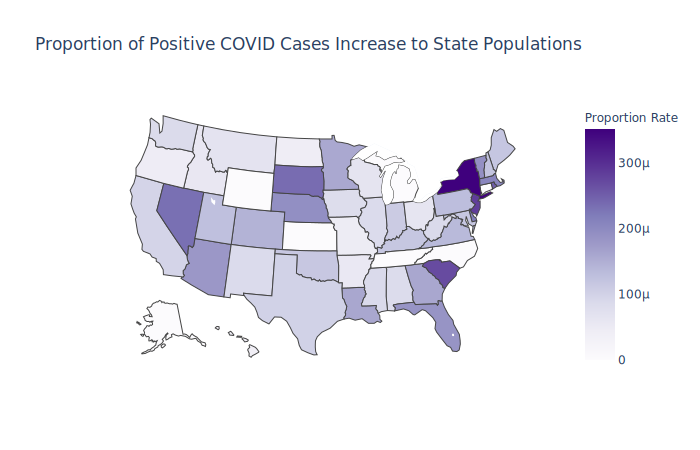

In [20]:
for i,j in state_code.iterrows():
    #setting state code initials for choropleths
    most_recent.loc[most_recent.state == state_code.loc[i]['State'], ['state']] = state_code.loc[i]['Abbreviation']

pio.renderers

fig = go.Figure(data=go.Choropleth(
    locations=most_recent['state'], # Spatial coordinates
    z = most_recent['proportion increase'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Purples',
    colorbar_title = "Proportion Rate",
))

fig.update_layout(
    title_text = 'Proportion of Positive COVID Cases Increase to State Populations',
    geo_scope='usa', # limite map scope to USA
)

fig.show(renderer="svg")

From above, we get to see how positive COVID cases have increased in our most recent datatset date. We see that **New York** has a relatively higher proportion compared to other states.

## Part 2: Vaccination and Hospitalization
Next we decide to take the column `people vaccinated` to calculate the proportion of people vaccinated per state. We insert the calculated proportions in a new column `proportion vaccination`. Then we made a barplot, histogram, and distribution plot showing our results. Using a choropleth map, then graphed the proportion of the number of people fully vaccinated and hospitalized currently.

From the barplot, we can compare the different proportion of people vaccinated from each state. From the histogram and distribution graph, we can see how many states have similar vaccination proportion. 
From the density graphs we can see that they skewed to the right.

In [21]:
most_recent['proportion vaccination'] = most_recent['people vaccinated']/most_recent['2020 population']
most_recent['people vaccinated'].isnull().sum()
most_recent

,date,state,hospitalized currently,hospitalized increase,positive,total test results,total test results increase,positive increase,total vaccinations,total distributed,people vaccinated,people fully vaccinated,daily vaccinations,hospital check,2020 population,proportion increase,proportion positive,proportion vaccination
0,2021-03-07,AK,33.0,0,56886.0,1731628.0,0,0,295046.0,426715.0,180948.0,113787.0,4329.0,True,731158,0.000000,0.077803,0.247481
1,2021-03-07,AL,494.0,0,499819.0,2323788.0,2347,408,1110132.0,1628350.0,727681.0,406723.0,23947.0,True,4921532,0.000083,0.101558,0.147857
2,2021-03-07,AR,335.0,11,324818.0,2736442.0,3380,165,765260.0,1088150.0,489149.0,274376.0,16564.0,True,3030522,0.000054,0.107182,0.161408
3,2021-03-07,AZ,963.0,44,826454.0,7908105.0,45110,1335,2162602.0,2623735.0,1388900.0,715023.0,52879.0,True,7421401,0.000180,0.111361,0.187148
4,2021-03-07,CA,4291.0,0,3501394.0,49646014.0,133186,3816,10634752.0,13885120.0,7205989.0,3347266.0,259101.0,False,39368078,0.000097,0.088940,0.183041
5,2021-03-07,CO,326.0,18,436602.0,6415123.0,38163,840,1626499.0,2019460.0,1046640.0,567922.0,36417.0,True,5807719,0.000145,0.075176,0.180215
6,2021-03-07,CT,428.0,0,285330.0,6520366.0,0,0,1195617.0,1434565.0,856048.0,325922.0,27307.0,True,3557006,0.000000,0.080216,0.240665
7,2021-03-07,DE,104.0,0,88354.0,1431942.0,5867,215,275467.0,361765.0,169956.0,97981.0,8022.0,False,986809,0.000218,0.089535,0.172228
8,2021-03-07,FL,3307.0,92,1909209.0,22339182.0,64599,4024,5900450.0,7771315.0,3714407.0,2045028.0,122290.0,True,21733312,0.000185,0.087847,0.170908
9,2021-03-07,GA,2008.0,35,1023487.0,7359069.0,18827,1709,2366573.0,3437635.0,1396280.0,894327.0,42017.0,True,10710017,0.000160,0.095564,0.130371


Text(0.5, 0, 'Proportion of Vaccinations to Total Population')

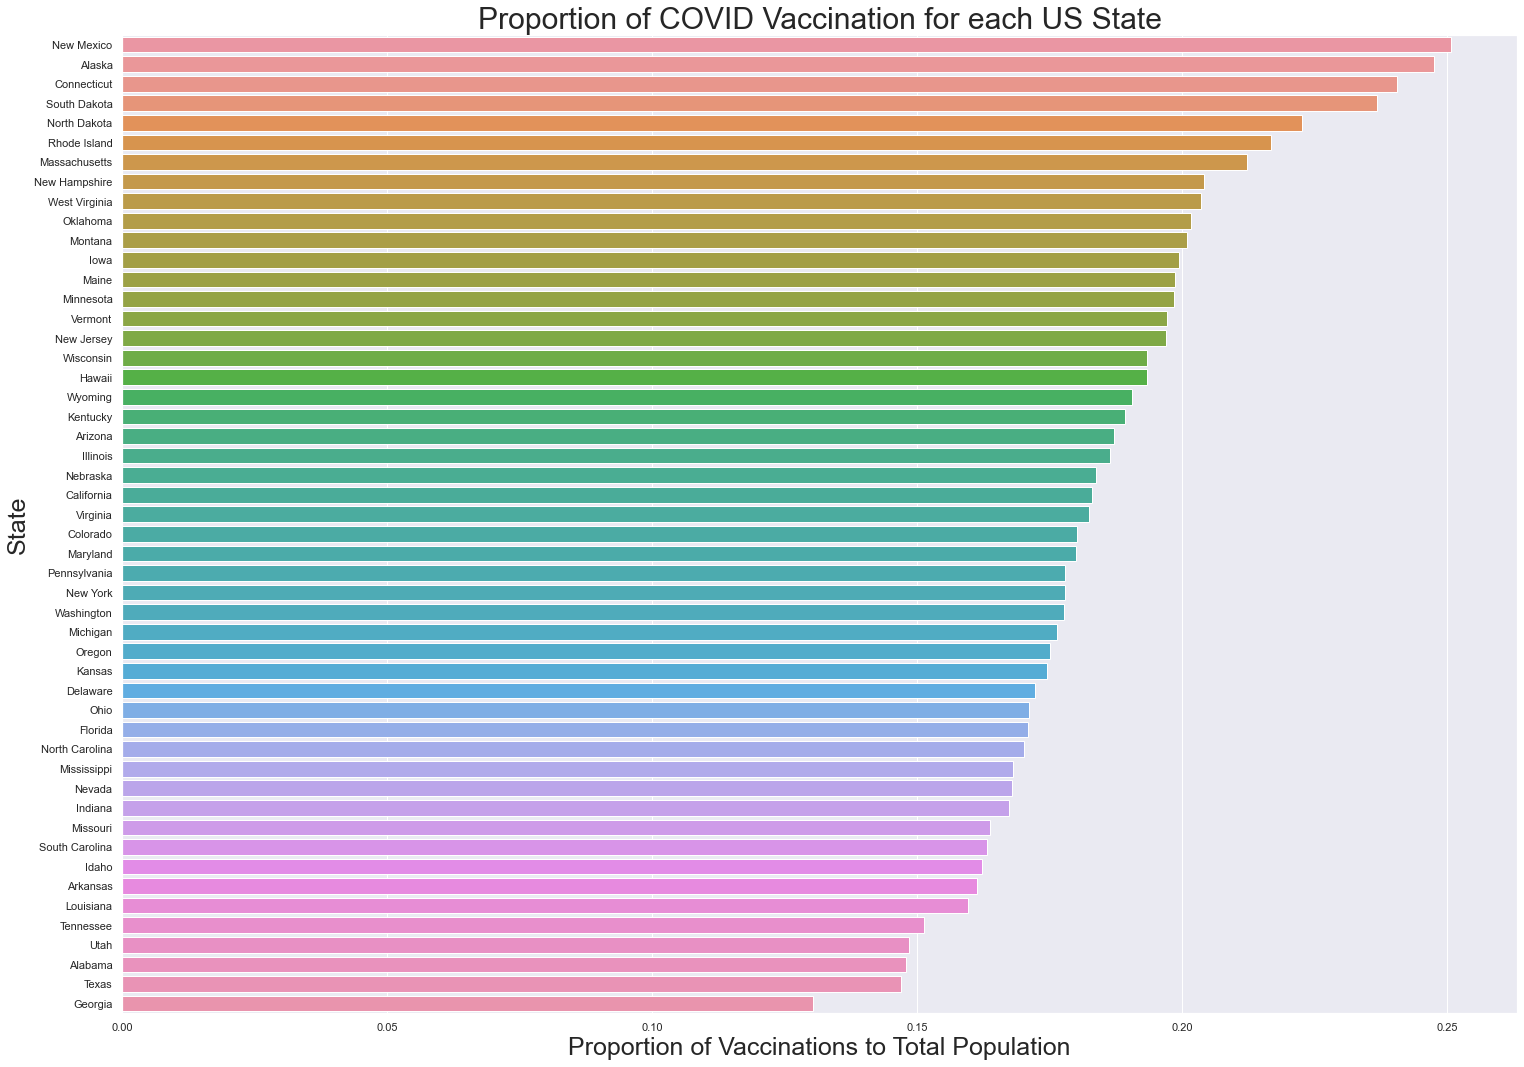

In [37]:

#temporarily reverting initials for clarity
for i,j in state_code.iterrows():
    most_recent.loc[most_recent.state == state_code.loc[i]['Abbreviation'], ['state']] = state_code.loc[i]['State']

sns.set(rc={'figure.figsize':(25,18)}, font_scale=1.3)
prop = sns.barplot(x=most_recent['proportion vaccination'], y='state',data=most_recent, order=most_recent.sort_values('proportion vaccination',ascending = False).state)

#Relabelling and scaling labels
prop.set_title("Proportion of COVID Vaccination for each US State", fontsize=30)
prop.set_ylabel("State", fontsize=25)
prop.set_xlabel("Proportion of Vaccinations to Total Population", fontsize=25)

<AxesSubplot:title={'center':'Histogram of Proportion of People Vaccinated for each US State'}, xlabel='Vaccinations Proportional to Population', ylabel='Count'>

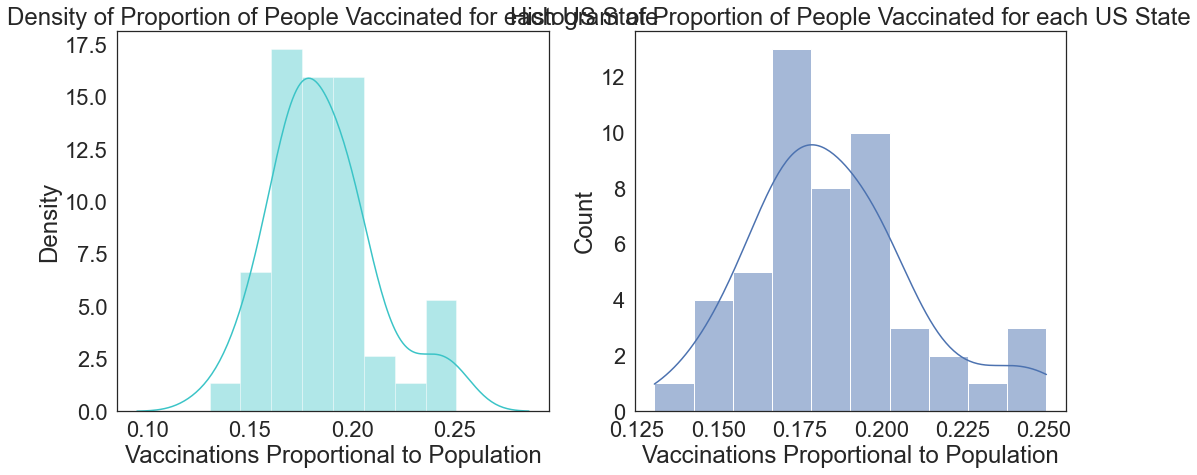

In [39]:
sns.set(style="white", rc={'figure.figsize':(17,7)}, font_scale=1.5)
plt.subplot(1, 2, 1)
sns.distplot(most_recent['proportion vaccination'], color='#3BC4C7').set(title="Density of Vaccination Proportions", xlabel="Vaccinations Proportional to Population")
plt.subplot(1, 2, 2)
sns.histplot(most_recent['proportion vaccination'], bins=10, kde=True).set(title="Histogram of Proportion of People Vaccinated for each US State", xlabel="Vaccinations Proportional to Population")
plt.subplot(1, 2, 2)

We further decided to create a choropleth map of the proportion vaccination values within the US. This shown below, we can easily see state with a darker green color showing higher proportion values. This gives us an idea of the states that have a higher vaccination percentage with regards to their population.

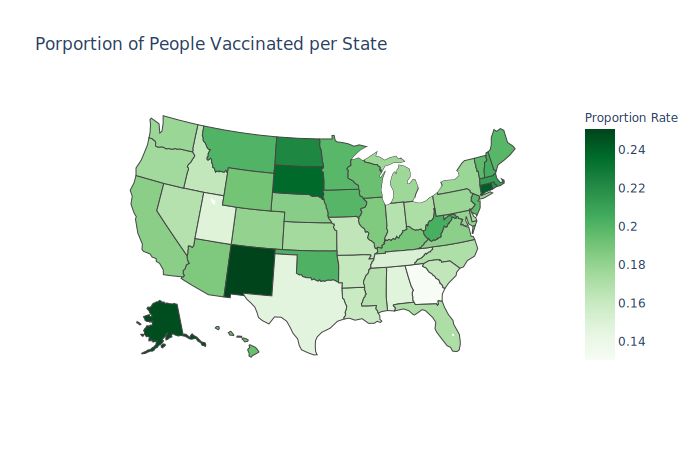

In [24]:
#resetting state code initials for choropleths
for i,j in state_code.iterrows():
    most_recent.loc[most_recent.state == state_code.loc[i]['State'], ['state']] = state_code.loc[i]['Abbreviation']

pio.renderers

fig = go.Figure(data=go.Choropleth(
    locations=most_recent['state'], # Spatial coordinates
    z = most_recent['proportion vaccination'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Proportion Rate",
))

fig.update_layout(
    title_text = 'Proportion of People Vaccinated per State',
    geo_scope='usa', # limite map scope to USA
)

fig.show(renderer="svg")

Next we want to explore the hospitialization records across the US using the column `hospitalized currently`. First we created another choropleth map to display the current proportion of citizen hospitialized per state. We calculated the proportion and placed the result in a new column called `proportion hospitalized`. From this we can which states have higher percentage of hospitialized citizens.

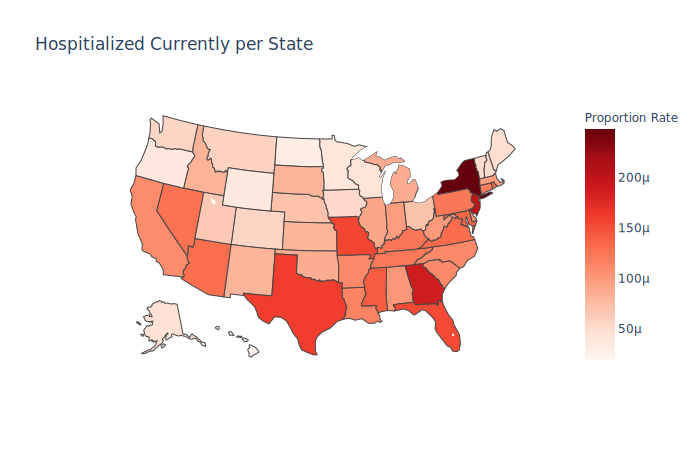

In [25]:
most_recent['proportion hospitalized'] = most_recent['hospitalized currently']/most_recent['2020 population']
fig2 = go.Figure(data=go.Choropleth(
    locations=most_recent['state'], # Spatial coordinates
    z = most_recent['proportion hospitalized'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Proportion Rate",
))

fig2.update_layout(
    title_text = 'Hospitialized Currently per State',
    geo_scope='usa', # limite map scope to USA
)

fig2.show(renderer="svg")

From the two choropleth maps above, we see that **New Mexico** and **Alaska** has the highest proportion of people vaccinated, while **New York** has the highest proportion of people currently hospitialized.

## Part 3: Looking at Lineplot Trends
Here we explored the positive COVID cases, hospital records and vaccination records of each state with a specific time frame; between the date 01/15/2021 to 03/08/2021. 

Since there are too many states to graph, we only looked at certain states like New York, Texas, and Utah. For each state we made four lineplots. First two showing the trend of positive COVID cases and positive COVID cases increase throughout two months. The last two showing the trend of hosipitialization records of those hopsitalized daily and the number of people vaccination based off of the specific date.

From the first graph of each state, we see that all of the state graphs show an upward trend. While their graphs look similar, they have different points in time where their cases increase and by how much they increase. We can assume all states have this upward trend throughout the year since this variable takes in consideration the total positive cases since the start of the pandemic, therefore the value of positive cases can only increase or stay constant as time passes. From the second graph, we see that positive COVID cases increase seem to be different throughout the month, although the peaks of the graphs seems to be decrease in value towards the most recent cases. 

From the last two graphs below we can see the different trends of hospital records and vaccination over 1 month. From the graphs we see that all three states have similar shapes within their trends. The line in the hospitalization graphs show a downward trend over the time period while the line in the vaccination graphs show an upward trend as more people start to get vaccinated. 

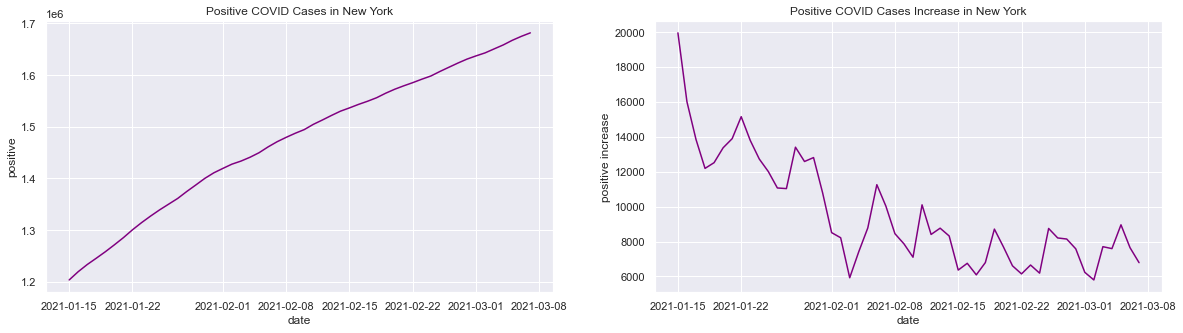

[Text(0.5, 1.0, 'People Vaccinated in New York')]

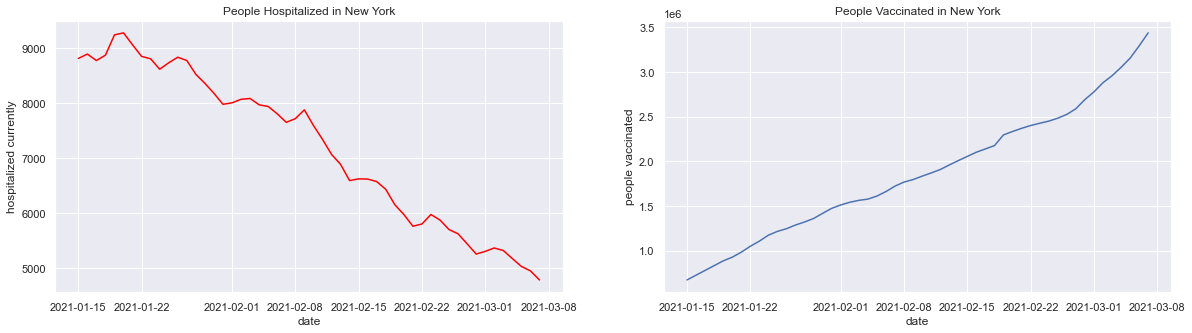

In [26]:
# Making a New York Data Frame
new_york_df = merged_data[merged_data['state'] == 'New York']
new_york_df['date'] = pd.to_datetime(new_york_df['date'])

# Plotting the lineplots
#sns.set(rc={'figure.figsize':(15,5)})
#sns.lineplot(x='date', y='positive', data=new_york_df, color='purple').set(title='Positive COVID Cases in New York')
#plt.show()
sns.set(rc={'figure.figsize':(20,5)})
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='positive', data=new_york_df, color='purple').set(title='Positive COVID Cases in New York')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='positive increase', data=new_york_df, color='purple').set(title='Positive COVID Cases Increase in New York')
plt.show()
sns.set(rc={'figure.figsize':(20,5)})
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='hospitalized currently', data=new_york_df, color='red').set(title='People Hospitalized in New York')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='people vaccinated', data=new_york_df).set(title='People Vaccinated in New York')

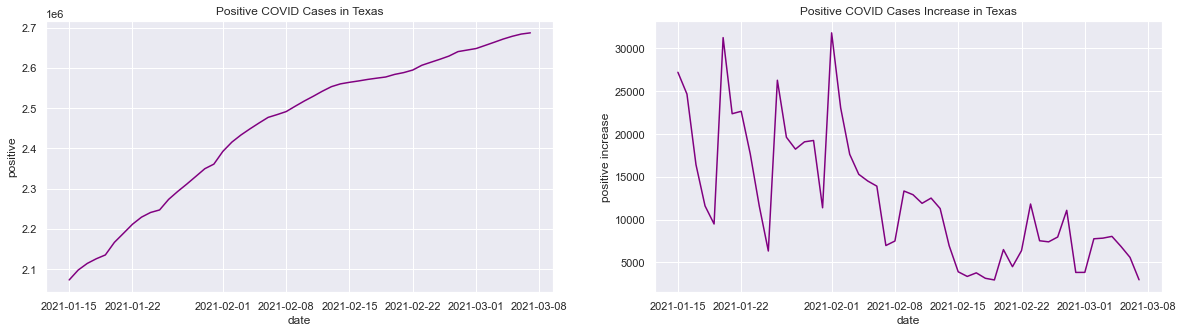

[Text(0.5, 1.0, 'People Vaccinated in Texas')]

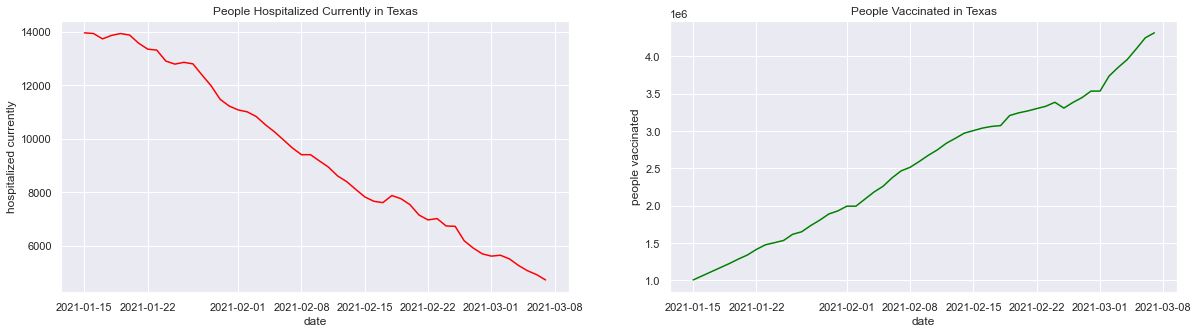

In [27]:
# Making the Texas DF
texas_df = merged_data[merged_data['state'] == 'Texas']
texas_df['date'] = pd.to_datetime(texas_df['date'])

# Plotting the lineplots
#sns.set(rc={'figure.figsize':(15,5)})
#sns.lineplot(x='date', y='positive', data=texas_df, color='purple').set(title='Positive COVID Cases in Texas')
#plt.show()
sns.set(rc={'figure.figsize':(20,5)})
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='positive', data=texas_df, color='purple').set(title='Positive COVID Cases in Texas')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='positive increase', data=texas_df, color='purple').set(title='Positive COVID Cases Increase in Texas')
plt.show()
sns.set(rc={'figure.figsize':(20,5)})
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='hospitalized currently', data=texas_df, color='red').set(title='People Hospitalized Currently in Texas')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='people vaccinated', data=texas_df, color='green').set(title='People Vaccinated in Texas')

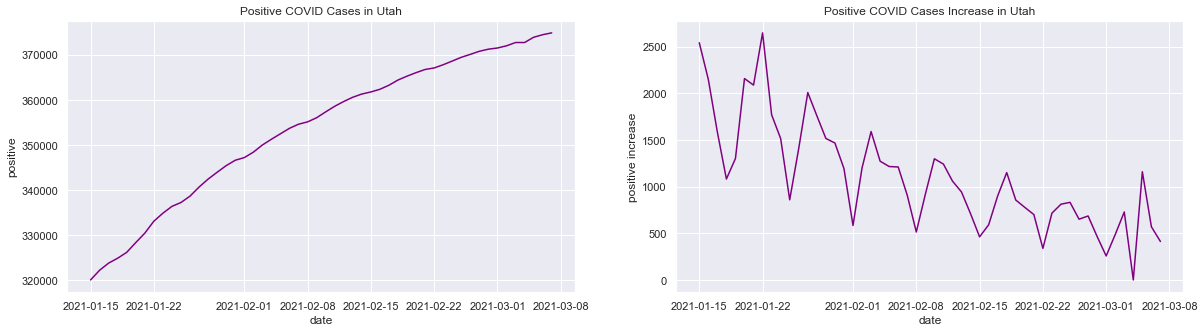

[Text(0.5, 1.0, 'People Vaccinated in Utah')]

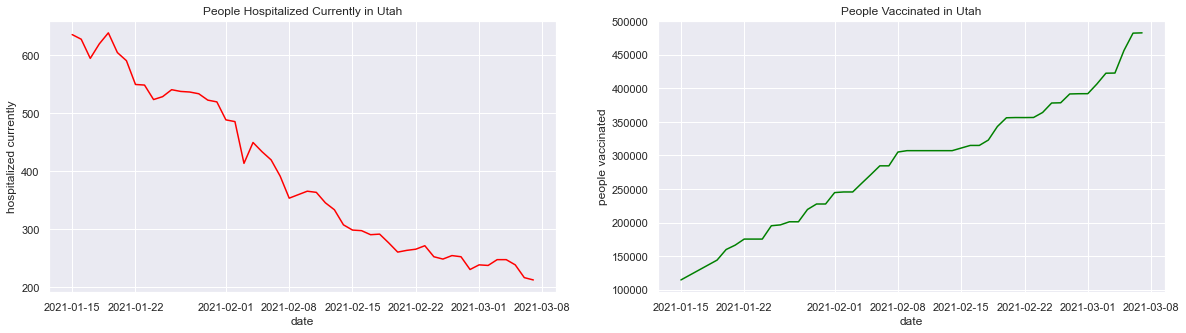

In [28]:
# Making the Utah DF
utah_df = merged_data[merged_data['state'] == 'Utah']
utah_df['date'] = pd.to_datetime(utah_df['date'])

# Plotting the lineplots
#sns.set(rc={'figure.figsize':(15,5)})
#sns.lineplot(x='date', y='positive', data=utah_df, color='purple').set(title='Positive COVID Cases in Utah')
#plt.show()
sns.set(rc={'figure.figsize':(20,5)})
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='positive', data=utah_df, color='purple').set(title='Positive COVID Cases in Utah')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='positive increase', data=utah_df, color='purple').set(title='Positive COVID Cases Increase in Utah')
plt.show()
sns.set(rc={'figure.figsize':(20,5)})
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='hospitalized currently', data=utah_df, color='red').set(title='People Hospitalized Currently in Utah')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='people vaccinated', data=utah_df, color='green').set(title='People Vaccinated in Utah')

## Part 4: Further Correlation
After looking at the lineplot trends above, we will now look at the correlation between variables in our dataset. We will focus on the variables `hospitalized currently`, `people vaccinated`, `people fully vaccinated`, `positive` and `positive increase`. We found the correlation between these variables listed above for every state. While finding the correlation, we also checked the p-value and printed out the states that had a p-value > 0.05. After finding the correlation of the variables for each state, we found the mean correlation and plotted a histogram showing the distribution of correlation from each state.


Before looking at the correlation, we plotted the variables `hospitalized currently` and `people vaccinated` into a regression plot to view the most fitted line. Below, we see that there is a good correlation between the two variables.

[Text(0.5, 1.0, 'Utah Hospital and Vaccination Correlation'),
 Text(0.5, 0, 'Hospitalized Currently'),
 Text(0, 0.5, 'People Vaccinated (Millions)')]

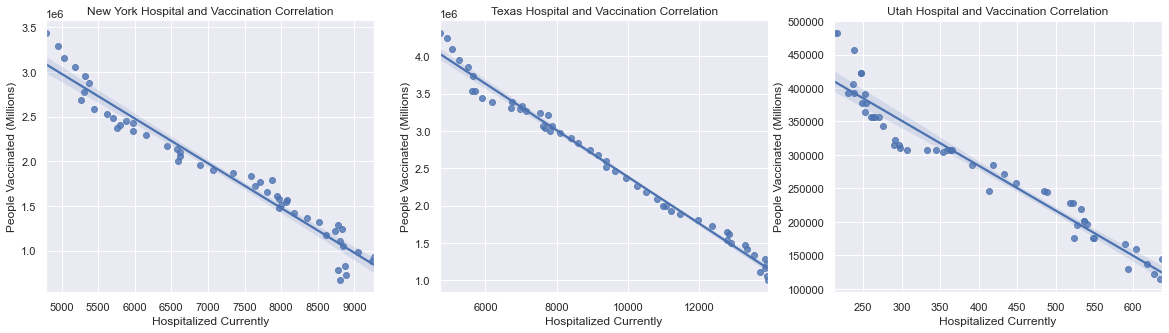

In [29]:
plt.subplot(1,3,1)
sns.regplot(data=new_york_df, x='hospitalized currently', y='people vaccinated').set(title='New York Hospital and Vaccination Correlation', xlabel='Hospitalized Currently', ylabel='People Vaccinated (Millions)')
plt.subplot(1,3,2)
sns.regplot(data=texas_df, x='hospitalized currently', y='people vaccinated').set(title='Texas Hospital and Vaccination Correlation', xlabel='Hospitalized Currently', ylabel='People Vaccinated (Millions)')
plt.subplot(1,3,3)
sns.regplot(data=utah_df, x='hospitalized currently', y='people vaccinated').set(title='Utah Hospital and Vaccination Correlation', xlabel='Hospitalized Currently', ylabel='People Vaccinated (Millions)')

In [30]:
states = state_code['State'].tolist()
states.remove('District of Columbia')

def correlation(var1, var2):
    corr_arr = []
    low_corr = []
    high_p = []
    for state_name in states:
        holder_df = merged_data[merged_data['state'] == state_name]
        corr_arr.append(stats.pearsonr(holder_df[var1], holder_df[var2])[0])
        if (stats.pearsonr(holder_df[var1], holder_df[var2])[1] > 0.05):
            p = stats.pearsonr(holder_df[var1], holder_df[var2])[1]
            #print(state_name + "'s p-value is a little too high : " + str(p))
            high_p.append(state_name)
            
        if ((stats.pearsonr(holder_df[var1], holder_df[var2])[0] < 0.5) & (stats.pearsonr(holder_df[var1], holder_df[var2])[0] > -0.5)):
            p = stats.pearsonr(holder_df[var1], holder_df[var2])[1]
            #print(state_name + "'s correlation is a little too low : " + str(p))
            low_corr.append(state_name)
            
    return corr_arr, low_corr, high_p

# Hospitalization and vaccination correlation
print('--- Correlation between hospitalized currently and people vaccinated ---')
hv_corr = correlation('hospitalized currently', 'people vaccinated')[0]
print('MEAN : ' + str(sum(hv_corr)/len(hv_corr)))
print('\n')

# Hospitalization and fully vaccination correlation
print('--- Correlation between hospitalized currently and people fully vaccinated ---')
hfv_corr = correlation('hospitalized currently', 'people fully vaccinated')[0]
print('MEAN : ' + str(sum(hfv_corr)/len(hfv_corr)))
print('\n')


# Positive COVID and hospitalized currently
print('--- Correlation between positive covid rates and hospitalized currently ---')
ph_corr = correlation('positive', 'hospitalized currently')[0]
print('MEAN : '+str(sum(ph_corr)/len(ph_corr)))
print('\n')

# Positive COVID and fully vaccination correlation
print('--- Correlation between positive covid rates and people fully vaccinated ---')
pfv_corr = correlation('positive', 'people fully vaccinated')[0]
print('MEAN : '+str(sum(pfv_corr)/len(pfv_corr)))
print('\n')

# Positive COVID increase and Hospitalized
print('--- Correlation between positive increase and hospitalized currently ---')
pih_corr, pih_low_corr, pih_high_p  = correlation('positive increase', 'hospitalized currently')
print('MEAN : ' + str(sum(pih_corr)/len(pih_corr)))
print('States with high p-values : ')
print(pih_high_p)
print('States with lower correlation : ')
print(pih_low_corr)
print('\n')

# Positive COVID increase and fully vaccination correlation
print('--- Correlation between positive increase and people fully vaccinated ---')
pifv_corr, pifv_low_corr, pifv_high_p = correlation('positive increase', 'people fully vaccinated')
print('MEAN : ' + str(sum(pifv_corr)/len(pifv_corr)))
print('States with high p-values : ')
print(pifv_high_p)
print('States with lower correlation : ')
print(pifv_low_corr)
print('\n')


--- Correlation between hospitalized currently and people vaccinated ---
MEAN : -0.9468585938738983


--- Correlation between hospitalized currently and people fully vaccinated ---
MEAN : -0.910754661124518


--- Correlation between positive covid rates and hospitalized currently ---
MEAN : -0.965251995819187


--- Correlation between positive covid rates and people fully vaccinated ---
MEAN : 0.9167660215101496


--- Correlation between positive increase and hospitalized currently ---
MEAN : 0.6881318890358687
States with high p-values : 
['Alaska', 'Vermont']
States with lower correlation : 
['Alaska', 'Connecticut', 'Idaho', 'Kansas', 'North Dakota', 'Michigan', 'South Dakota', 'Vermont', 'Washington']


--- Correlation between positive increase and people fully vaccinated ---
MEAN : -0.6213664915205268
States with high p-values : 
['Alaska', 'South Dakota', 'Vermont']
States with lower correlation : 
['Alaska', 'Colorado', 'Connecticut', 'Idaho', 'Kansas', 'Nebraska', 'North Dakota

From the calculations above we see that the correlation with the use of the positive increase variable seem to be weaker than the other variables. This most likely due to the noncontinuous trends seen above in part 4. While it does not have a strong correlation value, it still has some correlation with the variables hospitalized currently and people fully vaccinated.

[Text(0.5, 1.0, 'Count of Correlation between Positive Cases Increase and People Fully Vaccinated'),
 Text(0.5, 0, 'Correlation Value')]

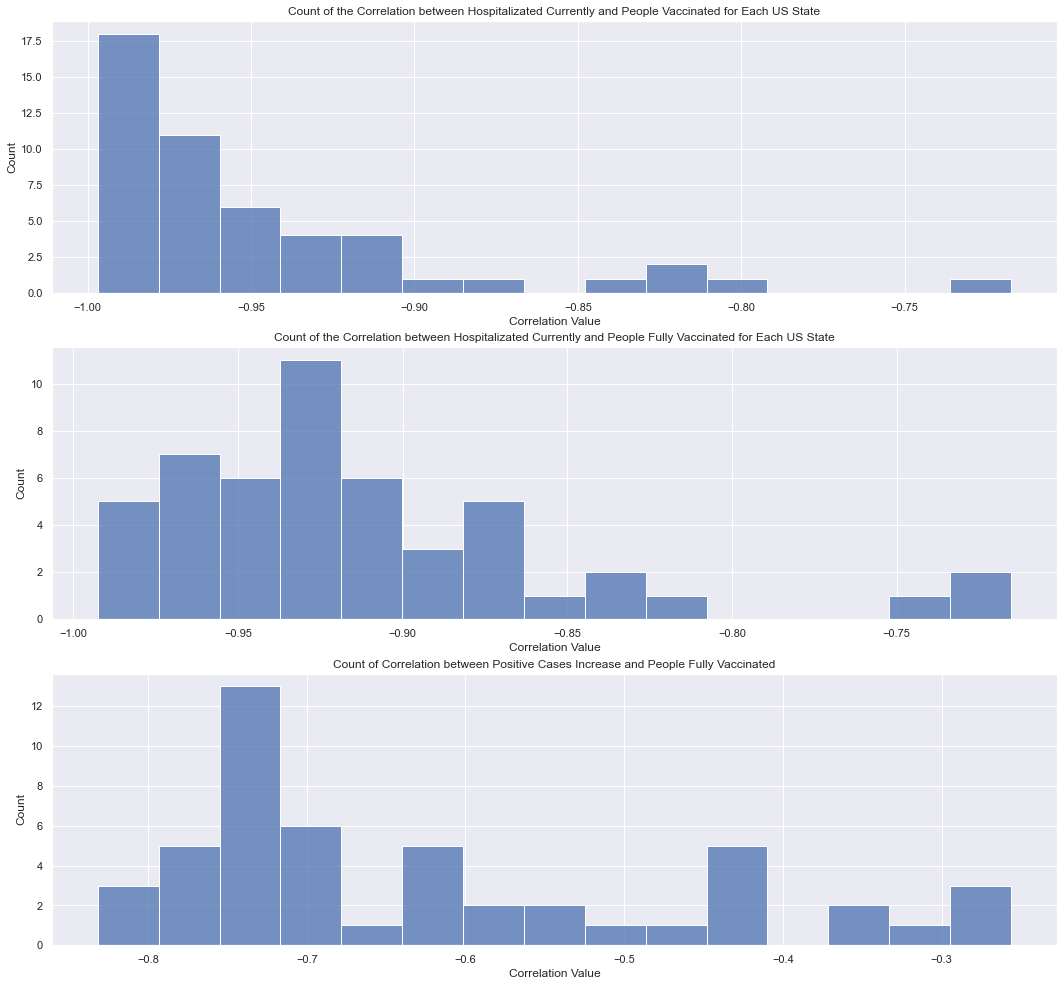

In [31]:
sns.set(rc={'figure.figsize':(18,17)})
plt.subplot(3,1,1)
sns.histplot(hv_corr, bins=15).set(title='Count of the Correlation between Hospitalizated Currently and People Vaccinated for Each US State', xlabel='Correlation Value')
plt.subplot(3,1,2)
sns.histplot(hfv_corr, bins=15).set(title='Count of the Correlation between Hospitalizated Currently and People Fully Vaccinated for Each US State', xlabel='Correlation Value')
plt.subplot(3,1,3)
sns.histplot(pifv_corr, bins=15).set(title='Count of Correlation between Positive Cases Increase and People Fully Vaccinated', xlabel='Correlation Value')

This analysis showed us that the variables `hospitalized currently` and `people fully vaccinated` had a good correlation distribution. The mean correlation for these variables averaged to -0.91, showing us that the two variables have a negative correlation. This can also be used to explain the trends seen above. While `people fully vaccinated` increases, `hospitalized currently` decreases.

With the density plots above, we can also see that there are some states with weaker correlation value for the variables `positive increase` and `people fully vaccinated`. We can see the states with weaker correlation in the correlation calculation cell above.

## Part 5: Ranking the States

We will now rank the states multiple ways. The first method of ranking is based off of the proportion of people fully vaccinated for each state. The higher the proportion, the lower rank number the state gets. The second method is ranking based off of the proportion of hospitalized currently for each state. The higher proportion of people hospitalized, the higher the rank number the state gets. The last method of ranking is taking the sum of the ranking methods above.

To get the values used for ranking, we will use our `most_recent` dataset contain our most recent values for the variables used. We used the variables `people fully vaccinated` and `hospitalized currently` because it is the variables which we will base our results in.

In [32]:
most_recent['proportion fully vaccination'] = most_recent['people fully vaccinated']/most_recent['2020 population']

for i,j in state_code.iterrows():
    most_recent.loc[most_recent.state == state_code.loc[i]['Abbreviation'], ['state']] = state_code.loc[i]['State']

# The higher proportion vaccinated, the lower the rank
fvacc_rank = dict()
rank = 1
for (index_label, row_series) in most_recent.sort_values(by = 'proportion fully vaccination').iloc[::-1].iterrows():
    #print(fully_vax_rank.loc[index_label, 'state'])
    fvacc_rank[most_recent.loc[index_label, 'state']] = rank
    rank += 1

# The lower the proportion of hospitalized, the lower the rank number
hospital_rank = dict()
rank = 1
for (index_label, row_series) in most_recent.sort_values(by = 'proportion hospitalized').iterrows():
    #print(fully_vax_rank.loc[index_label, 'state'])
    hospital_rank[most_recent.loc[index_label, 'state']] = rank
    rank += 1
    
# The sum ranking
rank_sum = dict()
for i in range(0,50):
    s = states[i]
    rank_sum[s] = hospital_rank[s] + fvacc_rank[s]

In [33]:
most_recent.head(10)

,date,state,hospitalized currently,hospitalized increase,positive,total test results,total test results increase,positive increase,total vaccinations,total distributed,people vaccinated,people fully vaccinated,daily vaccinations,hospital check,2020 population,proportion increase,proportion positive,proportion vaccination,proportion hospitalized,proportion fully vaccination
0,2021-03-07,Alaska,33.0,0,56886.0,1731628.0,0,0,295046.0,426715.0,180948.0,113787.0,4329.0,True,731158,0.000000,0.077803,0.247481,0.000045,0.155626
1,2021-03-07,Alabama,494.0,0,499819.0,2323788.0,2347,408,1110132.0,1628350.0,727681.0,406723.0,23947.0,True,4921532,0.000083,0.101558,0.147857,0.000100,0.082642
2,2021-03-07,Arkansas,335.0,11,324818.0,2736442.0,3380,165,765260.0,1088150.0,489149.0,274376.0,16564.0,True,3030522,0.000054,0.107182,0.161408,0.000111,0.090538
3,2021-03-07,Arizona,963.0,44,826454.0,7908105.0,45110,1335,2162602.0,2623735.0,1388900.0,715023.0,52879.0,True,7421401,0.000180,0.111361,0.187148,0.000130,0.096346
4,2021-03-07,California,4291.0,0,3501394.0,49646014.0,133186,3816,10634752.0,13885120.0,7205989.0,3347266.0,259101.0,False,39368078,0.000097,0.088940,0.183041,0.000109,0.085025
5,2021-03-07,Colorado,326.0,18,436602.0,6415123.0,38163,840,1626499.0,2019460.0,1046640.0,567922.0,36417.0,True,5807719,0.000145,0.075176,0.180215,0.000056,0.097787
6,2021-03-07,Connecticut,428.0,0,285330.0,6520366.0,0,0,1195617.0,1434565.0,856048.0,325922.0,27307.0,True,3557006,0.000000,0.080216,0.240665,0.000120,0.091628
7,2021-03-07,Delaware,104.0,0,88354.0,1431942.0,5867,215,275467.0,361765.0,169956.0,97981.0,8022.0,False,986809,0.000218,0.089535,0.172228,0.000105,0.099291
8,2021-03-07,Florida,3307.0,92,1909209.0,22339182.0,64599,4024,5900450.0,7771315.0,3714407.0,2045028.0,122290.0,True,21733312,0.000185,0.087847,0.170908,0.000152,0.094096
9,2021-03-07,Georgia,2008.0,35,1023487.0,7359069.0,18827,1709,2366573.0,3437635.0,1396280.0,894327.0,42017.0,True,10710017,0.000160,0.095564,0.130371,0.000187,0.083504


Below is the ranking for the proportion of hospitalization for each state. We see that Hawaii has the lowest proportion of hospitalized currently, followed by North Dakota and Wyoming.

In [34]:
hospital_rank

{'Hawaii': 1,
 'North Dakota': 2,
 'Wyoming': 3,
 'Oregon': 4,
 'Minnesota': 5,
 'Wisconsin': 6,
 'Alaska': 7,
 'Maine': 8,
 'Vermont': 9,
 'New Hampshire': 10,
 'Iowa': 11,
 'Washington': 12,
 'Colorado': 13,
 'Montana': 14,
 'Utah': 15,
 'Ohio': 16,
 'Nebraska': 17,
 'New Mexico': 18,
 'Kansas': 19,
 'South Dakota': 20,
 'Idaho': 21,
 'Michigan': 22,
 'Oklahoma': 23,
 'Illinois': 24,
 'Massachusetts': 25,
 'Indiana': 26,
 'West Virginia': 27,
 'Alabama': 28,
 'Delaware': 29,
 'California': 30,
 'Arkansas': 31,
 'South Carolina': 32,
 'North Carolina': 33,
 'Louisiana': 34,
 'Connecticut': 35,
 'Tennessee': 36,
 'Pennsylvania': 37,
 'Kentucky': 38,
 'Nevada': 39,
 'Arizona': 40,
 'Virginia': 41,
 'Rhode Island': 42,
 'Maryland': 43,
 'Mississippi': 44,
 'Florida': 45,
 'Missouri': 46,
 'Texas': 47,
 'Georgia': 48,
 'New Jersey': 49,
 'New York': 50}

Below is the ranking for the proportion of fully vaccination for each state. We see that Alaska has the lowest proportion of hospitalized currently, followed by New Mexico and West Virginia.

In [35]:
fvacc_rank

{'Alaska': 1,
 'New Mexico': 2,
 'West Virginia': 3,
 'South Dakota': 4,
 'Hawaii': 5,
 'North Dakota': 6,
 'Oklahoma': 7,
 'Montana': 8,
 'Wyoming': 9,
 'Wisconsin': 10,
 'Vermont': 11,
 'Indiana': 12,
 'Virginia': 13,
 'Nebraska': 14,
 'Maine': 15,
 'Minnesota': 16,
 'Maryland': 17,
 'Delaware': 18,
 'Washington': 19,
 'Oregon': 20,
 'New Jersey': 21,
 'Michigan': 22,
 'Colorado': 23,
 'Arizona': 24,
 'Massachusetts': 25,
 'Kentucky': 26,
 'Ohio': 27,
 'Florida': 28,
 'South Carolina': 29,
 'North Carolina': 30,
 'Connecticut': 31,
 'Idaho': 32,
 'Mississippi': 33,
 'Arkansas': 34,
 'Louisiana': 35,
 'Nevada': 36,
 'Kansas': 37,
 'Illinois': 38,
 'New York': 39,
 'Iowa': 40,
 'Rhode Island': 41,
 'New Hampshire': 42,
 'Missouri': 43,
 'California': 44,
 'Georgia': 45,
 'Alabama': 46,
 'Tennessee': 47,
 'Pennsylvania': 48,
 'Texas': 49,
 'Utah': 50}

Below is the score for the sum of both rankings above. As seen below, some states have tied. If the state has a lower score, this means that it is on track to be COVID free sooner than those states with higher scores.

In [36]:
{k: v for k, v in sorted(rank_sum.items(), key=lambda item: item[1])}

{'Hawaii': 6,
 'Alaska': 8,
 'North Dakota': 8,
 'Wyoming': 12,
 'Wisconsin': 16,
 'New Mexico': 20,
 'Vermont': 20,
 'Minnesota': 21,
 'Montana': 22,
 'Maine': 23,
 'Oregon': 24,
 'South Dakota': 24,
 'Oklahoma': 30,
 'West Virginia': 30,
 'Nebraska': 31,
 'Washington': 31,
 'Colorado': 36,
 'Indiana': 38,
 'Ohio': 43,
 'Michigan': 44,
 'Delaware': 47,
 'Massachusetts': 50,
 'Iowa': 51,
 'New Hampshire': 52,
 'Idaho': 53,
 'Virginia': 54,
 'Kansas': 56,
 'Maryland': 60,
 'South Carolina': 61,
 'Illinois': 62,
 'North Carolina': 63,
 'Arizona': 64,
 'Kentucky': 64,
 'Arkansas': 65,
 'Utah': 65,
 'Connecticut': 66,
 'Louisiana': 69,
 'New Jersey': 70,
 'Florida': 73,
 'Alabama': 74,
 'California': 74,
 'Nevada': 75,
 'Mississippi': 77,
 'Rhode Island': 83,
 'Tennessee': 83,
 'Pennsylvania': 85,
 'New York': 89,
 'Missouri': 89,
 'Georgia': 93,
 'Texas': 96}

# Ethics & Privacy

Regarding potential biases in our datasets, not every state may collect data with the same detail and thoroughness. Some regions may have fewer data-collection resources and are simply unable to provide highly-accurate data. As such, analysis based on hospital data may be biased toward regions that have more money, personnel, and space in their medical centers. Further, looking at testing and hospital data may exclude populations who have contracted COVID-19 but do not have the means to get tested. This may be problematic for equitable analysis because actions taken to get underperforming states to the same level as the states who are leading eradication of the disease may be misguided if the findings are biased. To handle this issue, we will seek data that accurately and equitably represents the population of the United States and datasets that are reliably reported.

There could potentially be an issue of patient privacy with the data we would like to use on vaccinations. If the data are not already anonymized to protect patient privacy, we would have to anonymize it prior to beginning exploratory data analysis and communicating our findings. Before analyzing the data we use, we will make sure to fully understand the information that is presented and identify where there may be bias or confounding factors. If any are identified, we will either incorporate appropriate new data into our analysis or seek new sources. When communicating our analysis, we will ensure that any potential misuses of our findings are addressed and that our analysis fully protects the privacy of patients involved.

# Conclusion & Discussion

From our rankings above, we conclude that the top three states most likely to be COVID free the earliest would be `Hawaii`, `Alaska`, and `North Dakota`. 

# Team Contributions

*Specify who in your group worked on which parts of the project.*